# Code Assignment — Residual ACF/PACF + Prophet (Builds on Last COVID-19 TS Assignment)

**Dataset (local CSV):** NYC COVID-19 daily counts (static export)  
**Target:** `case_count`

## Instructor Guidance (Documentation + Pseudocode)

**Docs**
- statsmodels ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html  
- ADF (adfuller): https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html  
- ACF/PACF: https://www.statsmodels.org/stable/graphics.html#autocorrelation-plots  
- Prophet: https://facebook.github.io/prophet/docs/quick_start.html  
- RMSE (sklearn MSE): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html  

**Pseudocode Workflow**
1) **Load CSV** → normalize columns; parse date.  
2) **Build daily time series** using `date_of_interest` as index; target = `case_count`; `asfreq('D')`; `interpolate('linear')`.  
3) **Chronological split (80/20)** → `train = first 80%`, `test = last 20%`.  
4) **Stationarity check (given)** → ADF on **differenced train**.  
5) **Baseline forecast (given)** → last train value for all test steps; compute **RMSE**.  
6) **ARIMA(1,1,1) (given)** → fit on **train**, forecast `len(test)`, compute **RMSE**; save **residuals**.  
7) **YOU DO:** Plot **ACF** and **PACF** of ARIMA **residuals**; comment on significant lags vs. bands.  
8) **YOU DO:** Fit **Prophet** on **train**, forecast over **test** horizon, compute **RMSE**, and plot vs. actuals.  
9) **YOU DO:** Plot residuals over time and write a 2–3 sentence interpretation.  
10) **Compare RMSEs** (Baseline vs. ARIMA vs. Prophet) and reflect on which generalizes best.

> **Note on Prophet installs:**  
> `pip install prophet cmdstanpy` then (one-time) `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`.


In [32]:
# STEP 0 — Imports  |  RUN THIS CELL WITHOUT CHANGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# For YOUR ACF/PACF step later
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1 — Load CSV and preview 


In [33]:
# RUN THIS CELL WITHOUT CHANGES Except changing filepath
DATA_PATH = '/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/covid.csv'   # <-- update path

df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower().str.strip()

date_col = "date_of_interest"
target_col = "case_count"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

# Coerce target to numeric (handles '1,141' strings)
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(",", "", regex=False), errors="coerce")

print("Range:", df[date_col].min(), "→", df[date_col].max())
df.head()

Range: 2020-02-29 00:00:00 → 2025-10-13 00:00:00


,date_of_interest,case_count,probable_case_count,hospitalized_count,death_count,case_count_7day_avg,all_case_count_7day_avg,hosp_count_7day_avg,death_count_7day_avg,bx_case_count,...,si_case_count,si_probable_case_count,si_hospitalized_count,si_death_count,si_probable_case_count_7day_avg,si_case_count_7day_avg,si_all_case_count_7day_avg,si_hospitalized_count_7day_avg,si_death_count_7day_avg,incomplete
0,2020-02-29,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-03,1,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-04,5,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Step 2 — Build daily time series and fill small gaps
- Set date index, `asfreq('D')`, `interpolate('linear')`.

In [34]:
# RUN THIS CELL WITHOUT CHANGES
s = df.set_index(date_col)[target_col].asfreq("D")
s = s.astype("float64").interpolate("linear")

print("Series:", target_col, "| length:", len(s), "| range:", s.index.min().date(), "→", s.index.max().date())
s.head()

Series: case_count | length: 2054 | range: 2020-02-29 → 2025-10-13


date_of_interest
2020-02-29   1.000
2020-03-01   0.000
2020-03-02   0.000
2020-03-03   1.000
2020-03-04   5.000
Freq: D, Name: case_count, dtype: float64

### Step 3 — Chronological split (80/20)
- First 80% → **train**; last 20% → **test**.


Train: 2020-02-29 → 2024-08-28 | n = 1643
Test : 2024-08-29 → 2025-10-13 | n = 411


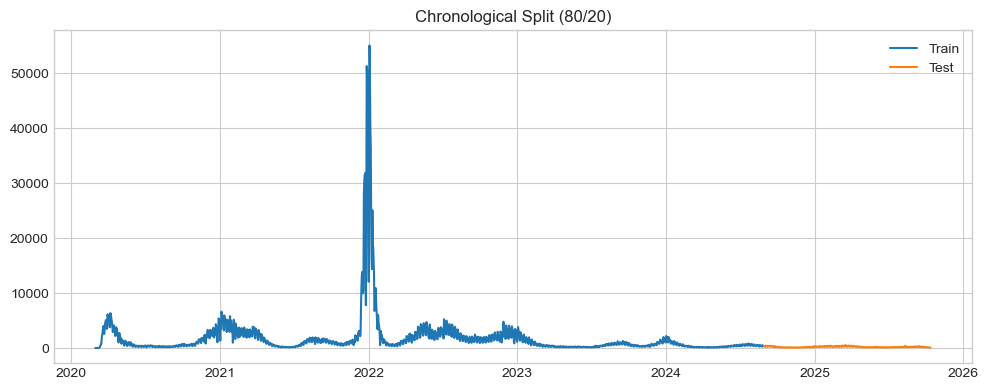

In [35]:
# RUN THIS CELL WITHOUT CHANGES
split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 4 — ADF on **differenced train** (stationarity check)
- If p < 0.05, **d=1** is reasonable in ARIMA.


In [36]:
# RUN THIS CELL WITHOUT CHANGES
diff_train = train.diff().dropna()
adf_stat, adf_p, _, _, crit, _ = adfuller(diff_train)
print(f"[ADF on differenced TRAIN] stat={adf_stat:.3f}, p={adf_p:.4f}")
for k, v in crit.items():
    print(f"  critical {k}: {v:.3f}")

[ADF on differenced TRAIN] stat=-9.677, p=0.0000
  critical 1%: -3.434
  critical 5%: -2.863
  critical 10%: -2.568


### Step 5 — Baseline (naïve/shift) forecast + RMSE
- Forecast = last train value repeated.

Baseline RMSE: 215.047


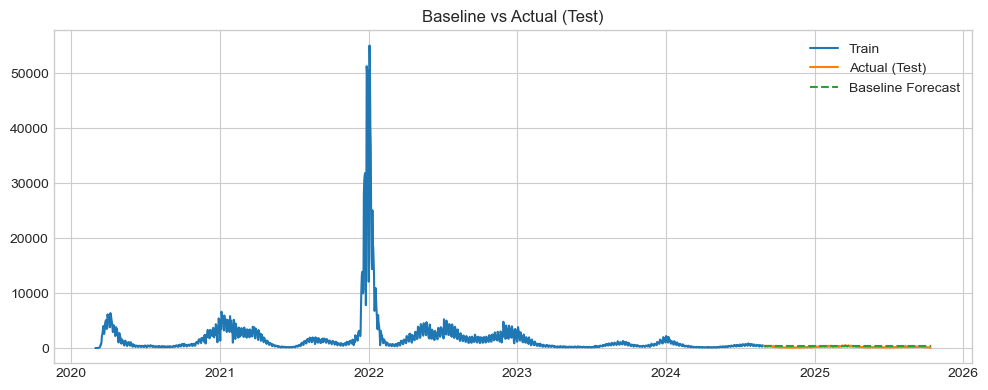

In [37]:
# RUN THIS CELL WITHOUT CHANGES
baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))

print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", ls="--")
plt.title("Baseline vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()

### Step 6 — ARIMA(1,1,1) fit → forecast → RMSE
- Fit on **train** only; forecast length = `len(test)`.

ARIMA(1,1,1) RMSE: 261.128


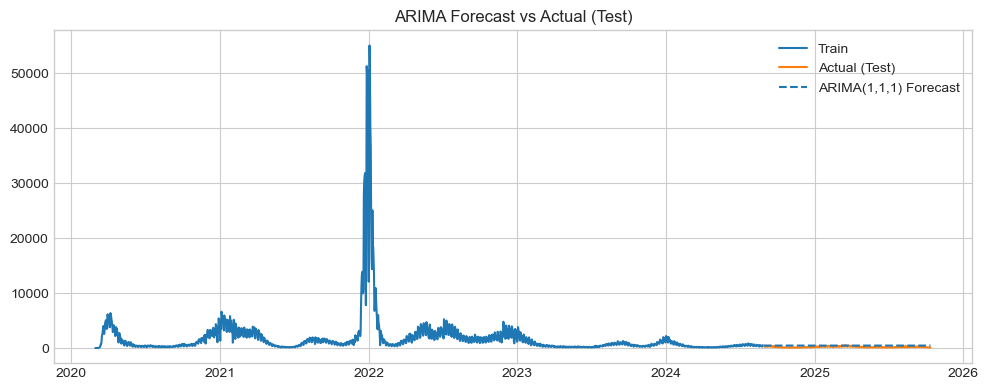

In [38]:
# RUN THIS CELL WITHOUT CHANGES
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
pred_arima = arima_model.forecast(steps=len(test))
rmse_arima = np.sqrt(mean_squared_error(test, pred_arima))
residuals = arima_model.resid  # save for diagnostics
print(f"ARIMA(1,1,1) RMSE: {rmse_arima:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(pred_arima, label="ARIMA(1,1,1) Forecast", color="#1f77b4", ls="--")
plt.title("ARIMA Forecast vs Actual (Test)")
plt.legend(); plt.tight_layout(); plt.show()


### Step 7 — YOU DO: Residual Diagnostics with ACF & PACF
- Plot **ACF** and **PACF** of `residuals` (from ARIMA).  
- Interpretation cues:
  - **Good:** bars mostly within bands → residuals ≈ white noise.  
  - **Spike at lag 7 or 12:** missed weekly/monthly seasonality → consider SARIMA.  
  - **PACF spike at lag p:** consider higher AR(p).  
  - **ACF spike at lag q:** consider higher MA(q).


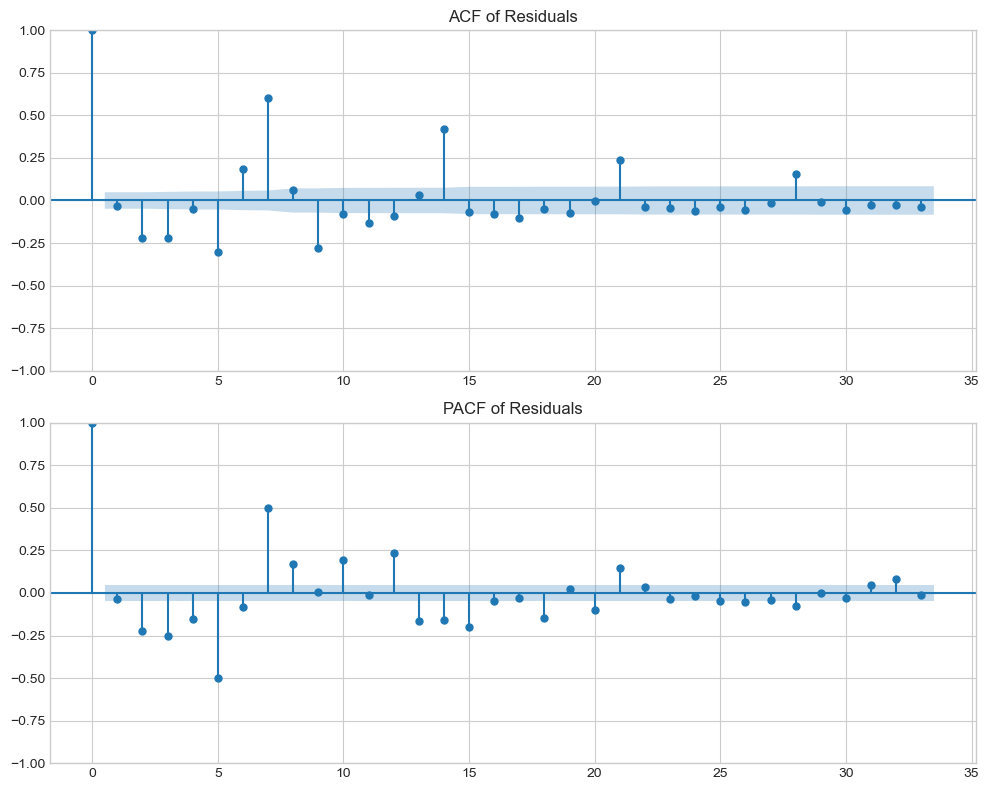

In [39]:
# Create a figure for the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot the ACF of the residuals
plot_acf(residuals, ax=ax[0])
ax[0].set_title('ACF of Residuals')

# Plot the PACF of the residuals
plot_pacf(residuals, ax=ax[1])
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


### Step 8 — YOU DO: Prophet model → forecast → RMSE
- Fit **Prophet** on **train** (rename columns to `ds` and `y`).  
- Forecast over the **test** horizon (same dates as `test.index`).  
- Compute **RMSE** and plot vs. actual.  
- If installation errors occur, install:
  - `pip install prophet cmdstanpy`
  - one-time: `python -c "import cmdstanpy; cmdstanpy.install_cmdstan()"`


In [40]:
from prophet import Prophet

# Let's rename the column names for prophet: 
# 'ds' for the datestamp
# 'y' for the value we want to forecast
df_prophet = s.reset_index()
df_prophet.columns = ['ds', 'y']
df_train = df_prophet.iloc[:-12]

In [41]:
df_prophet

,ds,y
0,2020-02-29,1.000
1,2020-03-01,0.000
2,2020-03-02,0.000
3,2020-03-03,1.000
4,2020-03-04,5.000
...,...,...
2049,2025-10-09,108.000
2050,2025-10-10,87.000
2051,2025-10-11,69.000
2052,2025-10-12,71.000


In [42]:
df_train

,ds,y
0,2020-02-29,1.000
1,2020-03-01,0.000
2,2020-03-02,0.000
3,2020-03-03,1.000
4,2020-03-04,5.000
...,...,...
2037,2025-09-27,96.000
2038,2025-09-28,126.000
2039,2025-09-29,226.000
2040,2025-09-30,189.000


In [60]:
# 1. Initialize and Fit
m = Prophet()
m.fit(df_train)

13:20:15 - cmdstanpy - INFO - Chain [1] start processing
13:20:15 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
df_test = df_prophet.iloc[-12:]

In [62]:
df_test

,ds,y
2042,2025-10-02,139.000
2043,2025-10-03,146.000
2044,2025-10-04,96.000
2045,2025-10-05,102.000
2046,2025-10-06,153.000
2047,2025-10-07,126.000
2048,2025-10-08,119.000
2049,2025-10-09,108.000
2050,2025-10-10,87.000
2051,2025-10-11,69.000


In [63]:
forecast = m.predict(df_test)

In [64]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds       yhat  yhat_lower  yhat_upper
7  2025-10-09   -288.439  -4,134.782   3,431.164
8  2025-10-10   -539.595  -4,510.729   3,384.154
9  2025-10-11 -1,025.293  -4,740.499   2,945.053
10 2025-10-12   -939.130  -4,800.180   2,910.162
11 2025-10-13    -67.568  -3,690.534   3,716.206


In [65]:
# Let's compute RMSE for prophet 
# 1. Extract actual values (last 12)
actual = df_prophet.iloc[-12:]['y']

# 2. Extract Prophet predictions (last 12)
preds = forecast.iloc[-12:]['yhat']

# 3. Compute RMSE
rmse_prophet = np.sqrt(mean_squared_error(actual, preds))
print("Prophet RMSE:", rmse_prophet)

Prophet RMSE: 720.8731746646232


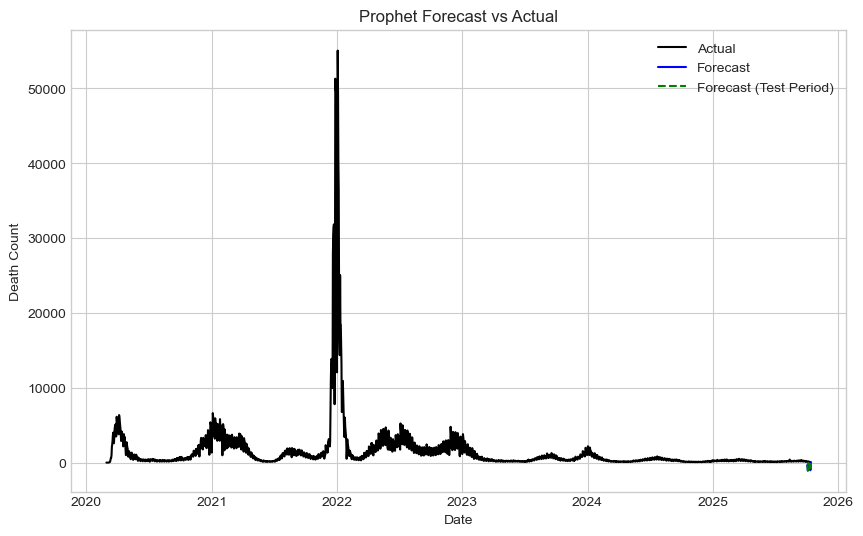

In [67]:
plt.figure(figsize=(10, 6))

# Plot actual
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='black')

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

plt.plot(forecast['ds'].iloc[-12:], forecast['yhat'].iloc[-12:], 
         label='Forecast (Test Period)', color='green', linestyle='--')

plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Death Count")
plt.show()


### Step 9 — YOU DO: Residuals over time + short interpretation
- Plot `residuals` vs. time; aim for random scatter around 0.  
- Write 2–3 sentences: Do residuals look like white noise? If not, what would you try (adjust p/q, SARIMA)?


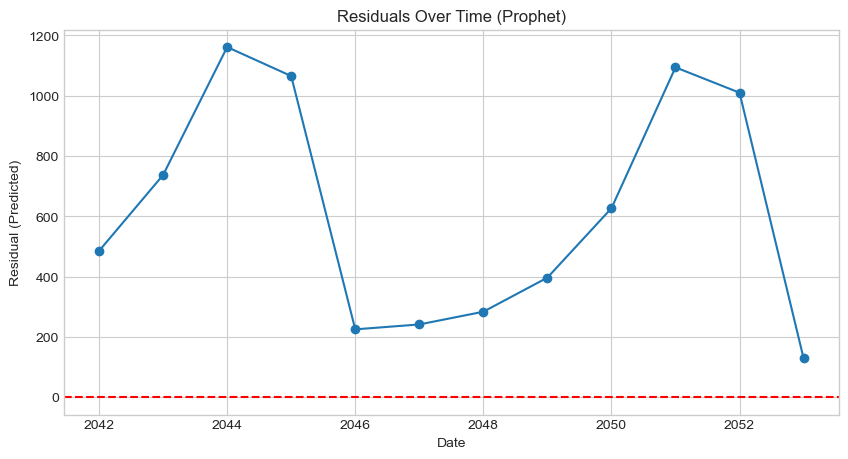

In [59]:
residual = actual.values - preds.values
plt.figure(figsize=(10, 5))
plt.plot(actual.index, residual, marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time (Prophet)")
plt.xlabel("Date")
plt.ylabel("Residual (Predicted)")
plt.show()



- The residual doesn't look like white noise, because all the bars in ACF/PACF plots of the residuals don't fall inside the light blue area. The model was not able to capture some important patterns(seasonality). Arima gave a wrong prediction, so the next step would be to try using SARIMA wich would check seasonal trends. 

### Step 10 — YOU DO:  Compare RMSEs and declare a winner
- Create a small table with Baseline, ARIMA, Prophet RMSEs.  
- Which model generalized best? By how much vs. baseline?


In [57]:
table = pd.DataFrame({
        "Models":['Baseline', 'Arima(1,1,1)', 'Prophet'],
        "RMSE":[f'{rmse_baseline:,.3f}', f'{rmse_arima:,.3f}', f'{rmse_prophet:,.3f}']
})

In [58]:
table

,Models,RMSE
0,Baseline,215.047
1,"Arima(1,1,1)",261.128
2,Prophet,720.873


- the first model generalized best by having the smallest RMSE 

## We Share — Reflection
- Did ACF/PACF suggest remaining structure (specific lags)? What change would you try first?
    - After plotting the ACF/PACF, we can see that the model didn't perform well. All the bars don't fall inside the light blue area, meaning that it doesn't capture all the patterns. What I would change first is to increase the value to the specific lag out of the light blue area. But because I have spikes, ARIMA is not the appropriate method here. I would consider using Prophet which is more advanced and better for capturing seasonality.
- Which model won on **RMSE**? Any business intuition why (trend shifts, seasonality, holiday effects)?  
    - The baseline model won against all the ARIMA and PROPHET models, having the smallest RMSE. That would predict that the historical data we have with the first model performs best in discovering any patterns within the data. This suggests that our baseline data is unpredictable for more complex models like ARIMA and PROPHET to find reliable patterns.
- If this went to production, what **guardrails** (intervals, fallback baseline, anomaly flags) would you put in place?
    - If this model went to production, I would implement anomaly flags guardrails to make sure that the model flags any problem in the training data before giving any false prediction. Based on past data, these guardrails will make sure that all future data predicted is accurate and trustworthy.
